### Problem
Wenn eine neue Support Anfrage eintrifft, wollen wir sie einer von 5 Kategorien zuordnen. Der Klassifizierer geht davon aus, dass jede neue Frage einer und nur einer Kategorie zugeordnet ist. Dies ist ein Problem mit der Klassifizierung von Texten mehrerer Klassen.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200
%matplotlib inline

### Toy corpus

In [2]:
corpus = [
    'Ich kann keine Bilder öffnen.',
    'Der Doppelklick auf Bilder funktioniert nicht mehr.',
    'In Buch Nr. 712 auf Seite 12 wurde ein Wort falsch geschrieben!',
    'Der Buchtitel wurde falsch geschrieben. NLKT wurde geschrieben anstatt NLTK!',
    'Ich kann die gekaufte Lizenz nicht mehr aktivieren. Was mache ich falsch?',
    'Die Lizenz funktioniert nicht!',
    'Ich kann mich nicht mehr einloggen.',
    'Mein Passwort scheint nicht mehr zu funktionieren!',
    'Ich kann micht nicht mit meinem Passwort mehr einloggen...',
    'Der Betrag wurde von meiner Kreditkarte abgezogen, das Buch habe ich immernoch nicht erhalten!',
    'Die Bezahlung wurde doppelt von meinem Konto abgebucht. #@!?$!!!',
    'Ich kann kein Geld auf mein Konto überweisen',
    'Zahlungen scheinen nicht zu funktionieren.',
    'Ich habe kein Geld mehr auf meinem Account!'
]

labels = ['bug', 'bug', 'grammar', 'grammar', 'license', 'license', 'login', 'login', 'login', 'payment', 'payment', 'payment', 'payment', 'payment']
ids = [0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4]
corpus = np.array(corpus)
corpus_df = pd.DataFrame(
    {
        'Document': corpus, 
        'Category': labels,
        'Cat_Id': ids
    }
)

corpus_df = corpus_df[['Document', 'Category', 'Cat_Id']]

category_id_df = corpus_df[['Category', 'Cat_Id']].drop_duplicates().sort_values('Cat_Id')
category_to_id = dict(category_id_df.values)
print(category_to_id)

id_to_category = dict(category_id_df[['Cat_Id', 'Category']].values)
print(id_to_category)

corpus_df

{'bug': 0, 'grammar': 1, 'license': 2, 'login': 3, 'payment': 4}
{0: 'bug', 1: 'grammar', 2: 'license', 3: 'login', 4: 'payment'}


,Document,Category,Cat_Id
0,Ich kann keine Bilder öffnen.,bug,0
1,Der Doppelklick auf Bilder funktioniert nicht mehr.,bug,0
2,In Buch Nr. 712 auf Seite 12 wurde ein Wort falsch geschrieben!,grammar,1
3,Der Buchtitel wurde falsch geschrieben. NLKT wurde geschrieben anstatt NLTK!,grammar,1
4,Ich kann die gekaufte Lizenz nicht mehr aktivieren. Was mache ich falsch?,license,2
5,Die Lizenz funktioniert nicht!,license,2
6,Ich kann mich nicht mehr einloggen.,login,3
7,Mein Passwort scheint nicht mehr zu funktionieren!,login,3
8,Ich kann micht nicht mit meinem Passwort mehr einloggen...,login,3
9,"Der Betrag wurde von meiner Kreditkarte abgezogen, das Buch habe ich immernoch nicht erhalten!",payment,4


### Check balance
Wenn wir auf solche Probleme stoßen, werden wir sicherlich Schwierigkeiten haben, sie mit Standardalgorithmen zu lösen. Herkömmliche Algorithmen sind oft auf die Mehrheitsklasse ausgerichtet und berücksichtigen nicht die Datenverteilung. Im schlimmsten Fall werden Minderheitenklassen als Ausreißer behandelt und ignoriert. Für einige Fälle müssten wir unser Modell sorgfältig konfigurieren oder den Datensatz künstlich ausbalancieren, z.B. durch Unter- oder Überabtastung jeder Klasse.

Im Falle unseres Lernens unausgewogener Daten könnten jedoch die Mehrheitsklassen von großem Interesse sein. Es ist wünschenswert, einen Klassifikator zu haben, der eine hohe Vorhersagegenauigkeit über die Mehrheitsklasse bietet, während die angemessene Genauigkeit für die Minderheitsklassen erhalten bleibt. Deshalb werden wir es so belassen, wie es ist.

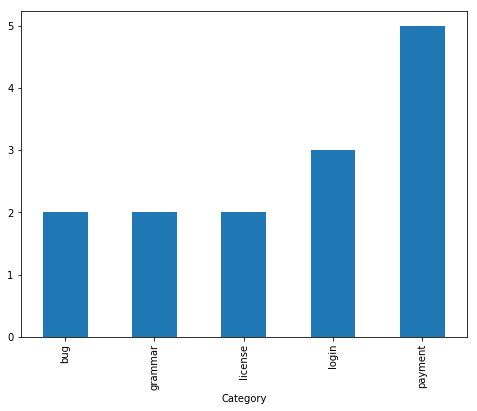

In [3]:
fig = plt.figure(figsize=(8,6))
corpus_df.groupby('Category').Document.count().plot.bar(ylim=0)
plt.show()

### Text Representation
Die Klassifikatoren und Lernalgorithmen können die Textdokumente nicht direkt in ihrer ursprünglichen Form verarbeiten, da die meisten von ihnen eher numerische Merkmalsvektoren mit fester Größe als die Rohtextdokumente mit variabler Länge erwarten. Daher werden die Texte während des Vorverarbeitungsschritts in eine übersichtlichere Darstellung umgewandelt.

Ein gängiger Ansatz für die Extraktion von Merkmalen aus dem Text ist die Verwendung des Worttaschenmodells: ein Modell, bei dem für jedes Dokument, eine Beschwerdeerzählung in unserem Fall, die Anwesenheit (und oft auch die Häufigkeit) von Wörtern berücksichtigt wird, aber die Reihenfolge, in der sie auftreten, ignoriert wird.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = ['ich', 'ein', 'der', 'die', 'das', 'mehr', 'auf', 'wurde', 'von', 'meinem', 'mache', 'mich', 'kann', 'scheint', 'was', 'zu', 'anstatt', 'scheinen']

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(corpus_df.Document).toarray()
labels = corpus_df.Category
features.shape

(14, 91)

In [8]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Document, Category in sorted(id_to_category.items()):
    features_chi2 = chi2(features, labels == Category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Document))
    print("**Most correlated unigrams:**\n- {}".format('\n- '.join(unigrams[-N:])))
    print("**Most correlated bigrams:**\n- {}".format('\n- '.join(bigrams[-N:])))

# '0':
**Most correlated unigrams:**
- öffnen
- bilder
**Most correlated bigrams:**
- keine bilder
- bilder öffnen
# '1':
**Most correlated unigrams:**
- nlkt
- geschrieben
**Most correlated bigrams:**
- geschrieben nltk
- falsch geschrieben
# '2':
**Most correlated unigrams:**
- aktivieren
- lizenz
**Most correlated bigrams:**
- nicht aktivieren
- lizenz funktioniert
# '3':
**Most correlated unigrams:**
- passwort
- einloggen
**Most correlated bigrams:**
- mein passwort
- nicht einloggen
# '4':
**Most correlated unigrams:**
- kein
- geld
**Most correlated bigrams:**
- zahlungen nicht
- kein geld


Nach wiederholtem anpassen der _stop_words_ bin ich nun mit den bigrams zufrieden.

### Naive Bayes Classifier

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(corpus_df['Document'], corpus_df['Category'], random_state = 0)
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()

X_train_tfidf  = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

Zeit für ein paar Support Anfragen zuordnen.
Ich achte darauf, dass die **bigrams** im Text erscheinen.

In [10]:
print(clf.predict(count_vect.transform(
    ['''
        Produkte werden **doppelt** auf meinem Konto **verbucht**
    ''']
)))

['payment']


In [11]:
print(clf.predict(count_vect.transform(
    ['''
        Ich kann **keine** Dokumente mehr **öffnen**!
    ''']
)))

['bug']


In [12]:
print(clf.predict(count_vect.transform(
    ['''
        Kann mich nicht mit meinem Passwort einloggen
    ''']
)))

['payment']


Okay schon haben wir einen Fehler. **Passwort** und **einloggen** müssten ein **login** Problem sein! 

Ich werde in einem späteren Schritt versuchen dieses Problem zu beheben.

### Vergleich

Ich möchte nun ein paar verschiedene Modelle vergleichen:
* Naive Bayes 
* Logistic Regression
* Random Forest
* Linear SVM

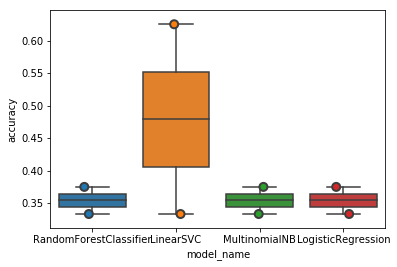

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(
        penalty='l2',
        dual=False,
        tol=0.0001,
        C=1.0,
        fit_intercept=True,
        intercept_scaling=1, 
        class_weight=None,
        random_state=None,
        solver='lbfgs',
        max_iter=100,
        multi_class='auto',
        verbose=0,
        warm_start=False,
        n_jobs=None)
]

CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.479167
LogisticRegression        0.354167
MultinomialNB             0.354167
RandomForestClassifier    0.354167
Name: accuracy, dtype: float64

LinearSVC scheint hier am besten abzuschliessen.

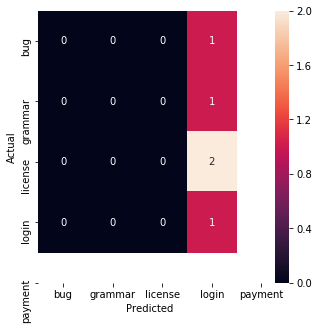

In [15]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Dies sieht nicht gut aus. Die diagonale sollte gefüllt sein und payment ist total leer...

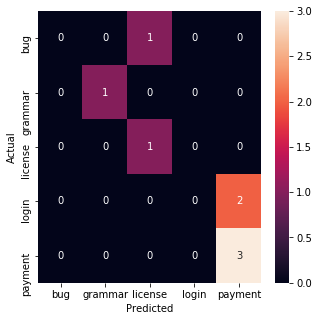

In [16]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, corpus_df.index, test_size=0.55, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Mit einer Testsize von 0.55 sind immerhin alle Felder vorhanden. Die diagonale ist aber immernoch nicht vollständig gefüllt.

In [17]:
from IPython.display import display

for predicted in category_id_df.Cat_Id:
    for actual in category_id_df.Cat_Id:
        if predicted != actual and conf_mat[actual, predicted] >= 0:
            # print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            # display(corpus_df.loc[0][['Category', 'Document']])
            #print('')
            
            print(y_test)

8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8       login
6       login
4     license
11    payment
2     grammar
13    payment
9     payment
1         bug
Name: Category, dtype: object
8     